In [109]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import seaborn as sns

plt.style.use('ggplot')
import warnings 
warnings.filterwarnings('ignore')

In [110]:
data = pd.read_csv('amazon_reviews.csv') 
  
print(data.shape) 
print(data.info())

(50557, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50557 entries, 0 to 50556
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              50557 non-null  object
 1   userName              50552 non-null  object
 2   content               50557 non-null  object
 3   score                 50557 non-null  int64 
 4   thumbsUpCount         50557 non-null  int64 
 5   reviewCreatedVersion  45708 non-null  object
 6   at                    50557 non-null  object
 7   appVersion            45708 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.1+ MB
None


In [111]:
data = data.head(10000)

In [112]:
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,313c5638-6584-4650-a62f-365cfb2f2d4f,Darphh,Li love amazon so much it has all the stuff I ...,5,0,28.9.2.100,2024-05-13 23:33:54,28.9.2.100
1,b47ca84a-9609-4815-8d9d-6425a1bef9e9,David B2431,loads quickly.,4,0,28.9.2.100,2024-05-13 23:24:28,28.9.2.100
2,349eeff6-453f-4eb6-a94f-214b0dcefc96,Sinai Luna,My packages have been coming late recently. Wh...,1,0,28.7.0.100,2024-05-13 23:24:19,28.7.0.100
3,017c8f1b-f5a7-4882-8b11-17d336e7444c,Cecilia Armenta,Excellent!!!,5,0,NaN,2024-05-13 23:23:45,NaN
4,e2f2ef27-c936-4d72-82d7-8ec5794ec0a0,Ashley Cyrus,absolutely love Amazon,5,0,28.9.2.100,2024-05-13 23:18:46,28.9.2.100


In [113]:
print("Null Values:\n", data.isna().sum()) 
  
data = data.dropna() 
  
print("Null Values after dropping:\n", data.isna().sum())

Null Values:
 reviewId                  0
userName                  1
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    679
at                        0
appVersion              679
dtype: int64
Null Values after dropping:
 reviewId                0
userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64


In [114]:
data['score'].value_counts()

score
1    4783
2    1634
5    1267
3    1079
4     557
Name: count, dtype: int64

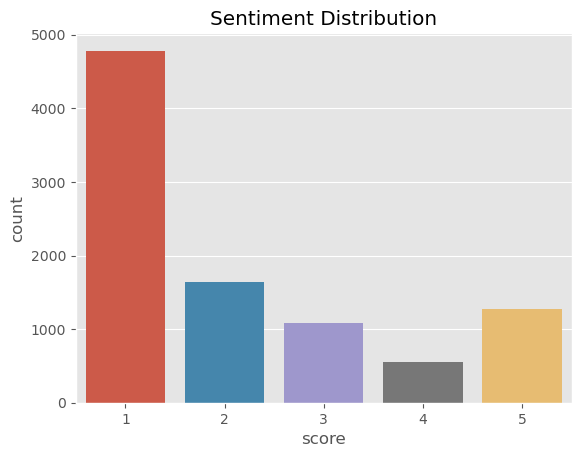

In [115]:
sns.countplot(x='score', data=data)
plt.title('Sentiment Distribution')
plt.show()


In [116]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [117]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['content']
    myid = row['reviewId']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/9320 [00:00<?, ?it/s]

In [118]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'reviewId'})
vaders = vaders.merge(data, how='left', on='reviewId')

In [119]:
vaders.head()

,reviewId,neg,neu,pos,compound,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,313c5638-6584-4650-a62f-365cfb2f2d4f,0.058,0.752,0.190,0.7906,Darphh,Li love amazon so much it has all the stuff I ...,5,0,28.9.2.100,2024-05-13 23:33:54,28.9.2.100
1,b47ca84a-9609-4815-8d9d-6425a1bef9e9,0.000,1.000,0.000,0.0000,David B2431,loads quickly.,4,0,28.9.2.100,2024-05-13 23:24:28,28.9.2.100
2,349eeff6-453f-4eb6-a94f-214b0dcefc96,0.000,0.963,0.037,0.3818,Sinai Luna,My packages have been coming late recently. Wh...,1,0,28.7.0.100,2024-05-13 23:24:19,28.7.0.100
3,e2f2ef27-c936-4d72-82d7-8ec5794ec0a0,0.000,0.134,0.866,0.7559,Ashley Cyrus,absolutely love Amazon,5,0,28.9.2.100,2024-05-13 23:18:46,28.9.2.100
4,614eb863-5d12-42e6-930f-87c2ec47604e,0.000,0.858,0.142,0.7684,Angelica Sosa,"the return section, as of recently, never seem...",4,0,28.9.2.100,2024-05-13 23:12:58,28.9.2.100


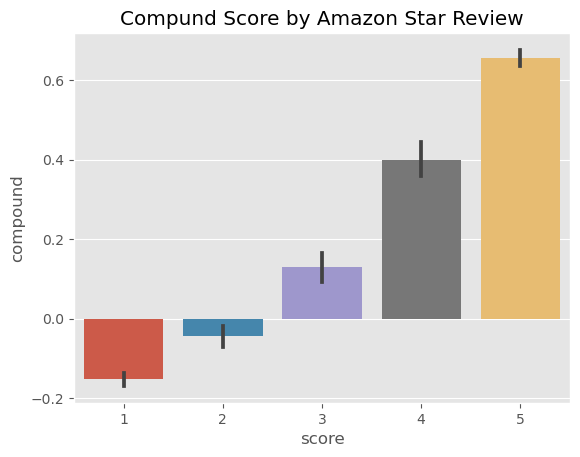

In [120]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

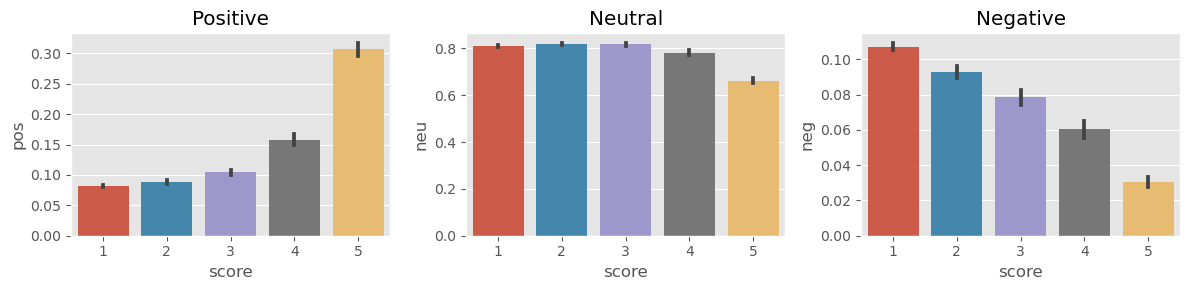

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [122]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [123]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

In [124]:
example =data['content'][10]
sia.polarity_scores(example)

{'neg': 0.179, 'neu': 0.724, 'pos': 0.097, 'compound': 0.4471}

In [125]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.96667886, 'roberta_neu': 0.0302774, 'roberta_pos': 0.0030437396}


In [126]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [127]:
scores = sia.polarity_scores(data['content'][0])
scores

{'neg': 0.058, 'neu': 0.752, 'pos': 0.19, 'compound': 0.7906}

In [128]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['content']
        myid = row['reviewId']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/9320 [00:00<?, ?it/s]

In [129]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'reviewId'})
results_df = results_df.merge(data, how='left', on='reviewId')

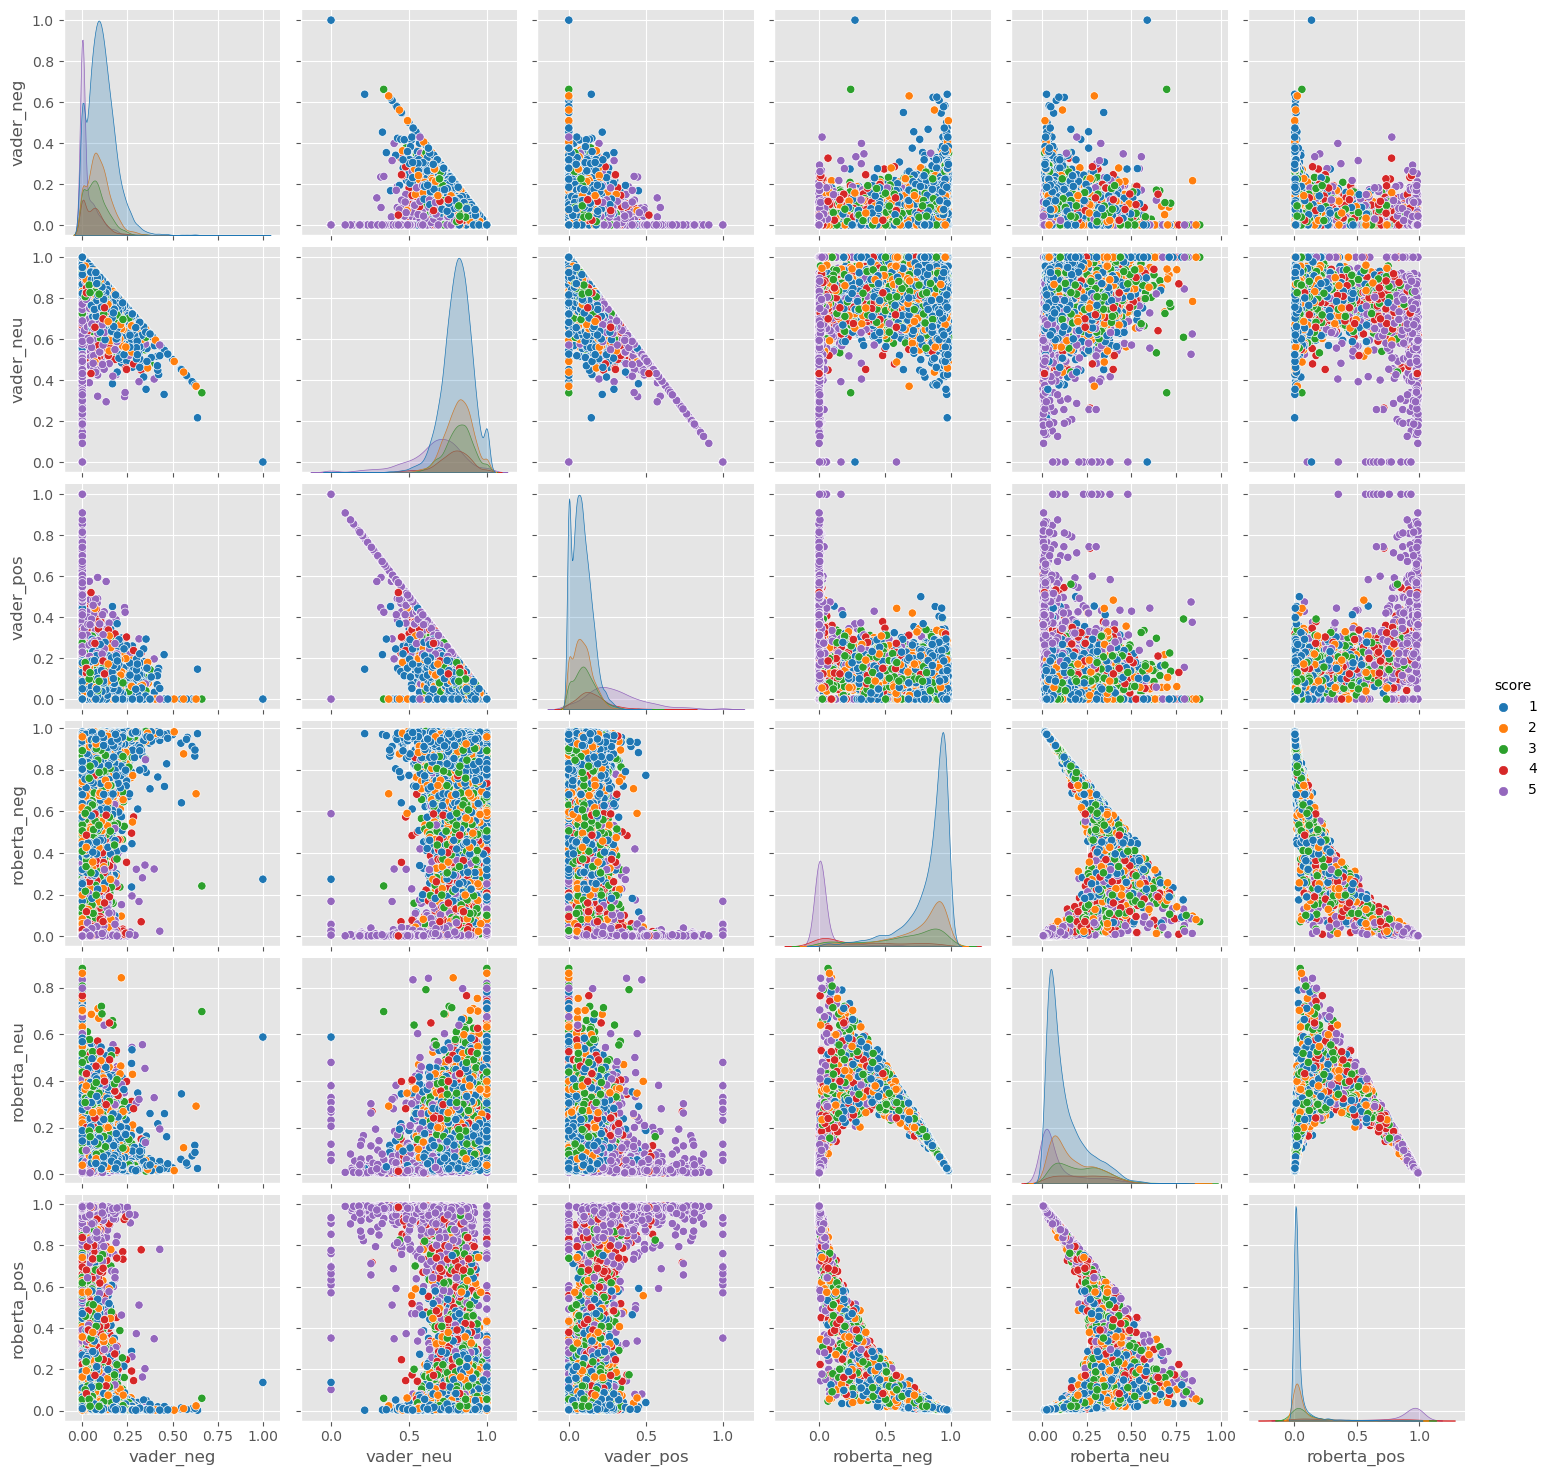

In [131]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='score',
            palette='tab10')
plt.show()

In [134]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [135]:
sent_pipeline('I love sleeping, and i want to eat something')


[{'label': 'POSITIVE', 'score': 0.9990741014480591}]